In this notebook you will see the steps for preprocessing the dataset, the first steps are quite static preprocessings steps made by Fabian.

Next Step is the quasi steady state filter which will be ran two times, 
- first for removing acceleration/deacceleration datapoints 
- second removing drifting by analyzing with more significant windows. 


In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.stats import t 
from sklearn.linear_model import LinearRegression
import numpy as np

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t
from scipy.signal import savgol_filter
import plotly.graph_objects as go



In [151]:
vessel_num = 4

vessel_1 = pd.read_csv(f'../../data/vessel{vessel_num}.csv')
#vessel_4 = pd.read_csv('../../data/vessel4.csv')
#vessel_5 = pd.read_csv('../../data/vessel5.csv')
#vessel_7 = pd.read_csv('../../data/vessel7.csv')

In [152]:
(len(vessel_1)),#len(vessel_4),len(vessel_5),len(vessel_7))

(317418,)

In [ ]:
vessel_1.describe()

## IF VESSEL 1, should be cut data from: cutoff = 369000

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

if vessel_num == 1: 
    vessel_1['timestamp'] = pd.to_datetime(vessel_1['timestamp'])

    vessel_1 = vessel_1[(vessel_1['fuel_consumption'] >= 0) & (vessel_1['fuel_consumption'] <= 3500)]

    cutoff_index = 368500
    cutoff = vessel_1.index[cutoff_index] if len(vessel_1) > cutoff_index else vessel_1.index[-1]

    operational_data = vessel_1[vessel_1.index <= cutoff]
    drifting_data = vessel_1[vessel_1.index > cutoff]

    plt.style.use('ggplot')

    plt.figure(figsize=(16, 8))

    plt.plot(vessel_1['timestamp'], vessel_1['fuel_consumption'], label='Fuel Consumption', color='grey', alpha=0.5)

    plt.scatter(operational_data['timestamp'], operational_data['fuel_consumption'], color='green', label='Operational Data', alpha=0.3)

    plt.scatter(drifting_data['timestamp'], drifting_data['fuel_consumption'], color='red', label='Drifting Period', alpha=0.7)

    plt.title('Fuel Consumption Over Time for dataset 1')
    plt.xlabel('Timestamp')
    plt.ylabel('Fuel Consumption (units)')
    plt.legend()
    plt.tight_layout()

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.gca().tick_params(axis='x', which='major', labelsize=10, rotation=0)


    plt.show()



IF VESSEL 1 REMOVE DRIFTING

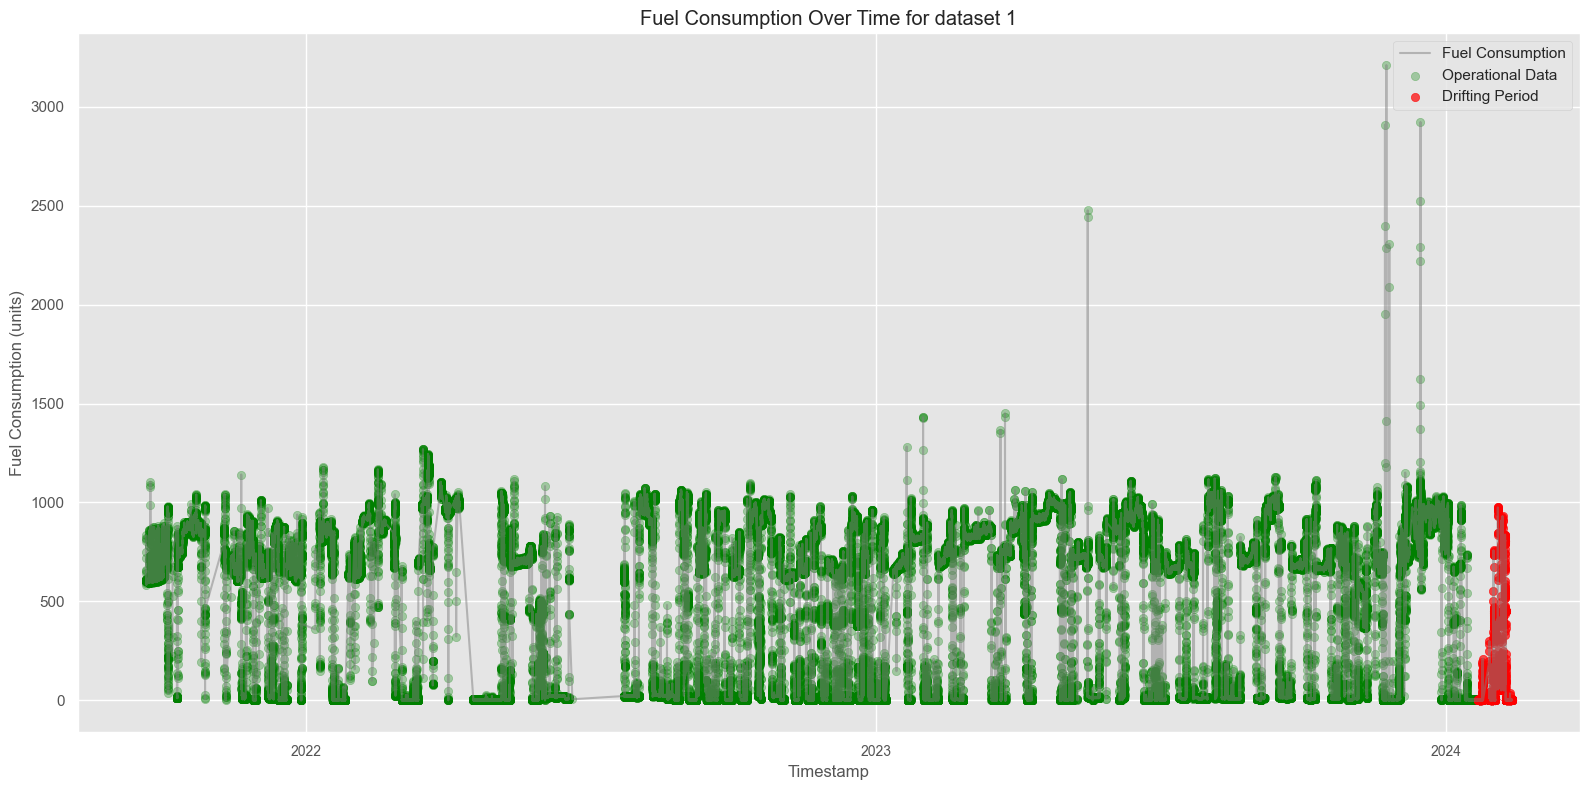

In [113]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

if vessel_num == 5: 
    vessel_1['timestamp'] = pd.to_datetime(vessel_1['timestamp'])

    vessel_1 = vessel_1[(vessel_1['fuel_consumption'] >= 0) & (vessel_1['fuel_consumption'] <= 3500)]

    cutoff_index = 199000
    cutoff = vessel_1.index[cutoff_index] if len(vessel_1) > cutoff_index else vessel_1.index[-1]

    operational_data = vessel_1[vessel_1.index <= cutoff]
    drifting_data = vessel_1[vessel_1.index > cutoff]

    plt.style.use('ggplot')

    plt.figure(figsize=(16, 8))

    plt.plot(vessel_1['timestamp'], vessel_1['fuel_consumption'], label='Fuel Consumption', color='grey', alpha=0.5)

    plt.scatter(operational_data['timestamp'], operational_data['fuel_consumption'], color='green', label='Operational Data', alpha=0.3)

    plt.scatter(drifting_data['timestamp'], drifting_data['fuel_consumption'], color='red', label='Drifting Period', alpha=0.7)

    plt.title('Fuel Consumption Over Time for dataset 1')
    plt.xlabel('Timestamp')
    plt.ylabel('Fuel Consumption (units)')
    plt.legend()
    plt.tight_layout()

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.gca().tick_params(axis='x', which='major', labelsize=10, rotation=0)


    plt.show()


In [114]:

if vessel_num == 1: 
    cutoff = 368500

    vessel_1 = vessel_1[vessel_1.index <= cutoff]

if vessel_num == 5: 
    cutoff = 199000
    vessel_1 = vessel_1[vessel_1.index <= cutoff]


Preprocess the dataset with:

* filter low speeds, 
* power & RPM filter lower than 10/20 of max filter RPM lower than 20. 
* Filter extreme fuel cons values with a generic metric of fuel per engine power. 
* water depth
* feature engineering. 
* Remove Missing Values


Note also the max fuel cons step should be ran based on the selected vessel, has not been implemented yet. Just looking at the overtime fuel consumption and removing obvious outlers such as fuel_cons > 3000 etc. 

In [154]:
vessel1_preprocessed = vessel_1.copy()

Remove Missing values

In [155]:
quartiles = vessel_1['fuel_consumption'].quantile([0.25, 0.5, 0.75,0.90])

min_speed = 2
min_rpm = 20
max_fuel_per_power = 0.8
min_fuel = 200

# max fuel should be part of the preprocessing to avoid high outliers, but its dependable on the vessel type and its fuel consumption distribution. 
#max_fuel = 4000
water_depth_cutover = 30

In [156]:
vessel1_preprocessed = vessel_1[vessel_1.speed_over_ground >= min_speed]
print("After removing min speed: ", len(vessel1_preprocessed))
vessel1_preprocessed = vessel1_preprocessed[vessel1_preprocessed.fuel_consumption > min_fuel]
print("After removing min fuel cons: ", len(vessel1_preprocessed))
#vessel1_preprocessed = vessel1_preprocessed[vessel1_preprocessed.fuel_consumption <= max_fuel]
#print("After removing max fuel cons: ",len(vessel1_preprocessed))

After removing min speed:  317416
After removing min fuel cons:  310138


In [157]:
len(vessel1_preprocessed)

310138

In [158]:
min_power = max(vessel1_preprocessed.power_consumption)*0.15
vessel1_preprocessed = vessel1_preprocessed[(vessel1_preprocessed.rpm >= min_rpm) & (vessel1_preprocessed.power_consumption >= min_power)]

In [159]:
len(vessel1_preprocessed)

285073

In [160]:
vessel1_preprocessed['fuel_per_power'] = vessel1_preprocessed.fuel_consumption / vessel1_preprocessed.power_consumption
vessel1_preprocessed = vessel1_preprocessed[vessel1_preprocessed.fuel_per_power <= max_fuel_per_power]

In [161]:
len(vessel1_preprocessed)

284719

In [162]:
water_depth = 30
vessel1_preprocessed['water_depth_combined'] = vessel1_preprocessed.apply(lambda row: row.water_depth_measured if row.water_depth_measured <= water_depth_cutover else row.water_depth_forecast, axis=1)


In [163]:
len(vessel1_preprocessed)

284719

In [164]:
na_counts = vessel1_preprocessed.isna().sum()
print(na_counts)

timestamp                    0
speed_through_water          0
speed_over_ground            0
heading                      0
course_over_ground           0
power_consumption            0
rpm                          0
draft_aft                    0
draft_fwd                    0
fuel_consumption             0
wind_speed                   0
wind_direction               0
wind_u_component             0
wind_v_component             0
waveheight                   0
wavedirection                0
waveperiod                   0
swellheight                  0
swelldirection               0
swellperiod                  0
water_depth_forecast         0
water_depth_measured     36503
sea_water_temperature     2987
current_speed                0
current_direction            0
estimatedStaticFOC        4186
estimatedStaticPower      4186
estimatedStaticRPM        4186
fuel_per_power               0
water_depth_combined         0
dtype: int64


Feature engineering: 

Calculating mean draft, trim and relatives. 

In [165]:
vessel1_preprocessed['mean_draft'] = vessel1_preprocessed[['draft_aft', 'draft_fwd']].mean(axis=1)

vessel1_preprocessed['trim'] = vessel1_preprocessed['draft_fwd'] - vessel1_preprocessed['draft_aft'] #other way around

vessel1_preprocessed['relative_wind_direction_cog'] = (vessel1_preprocessed['wind_direction'] - vessel1_preprocessed['course_over_ground']) % 360
vessel1_preprocessed['relative_wave_direction_cog'] = (vessel1_preprocessed['wavedirection'] - vessel1_preprocessed['course_over_ground']) % 360
vessel1_preprocessed['relative_swell_direction_cog'] = (vessel1_preprocessed['swelldirection'] - vessel1_preprocessed['course_over_ground']) % 360
vessel1_preprocessed['relative_current_direction_cog'] = (vessel1_preprocessed['current_direction'] - vessel1_preprocessed['course_over_ground']) % 360

In [166]:
len(vessel1_preprocessed)

284719

Checking correlations if they make sense. 

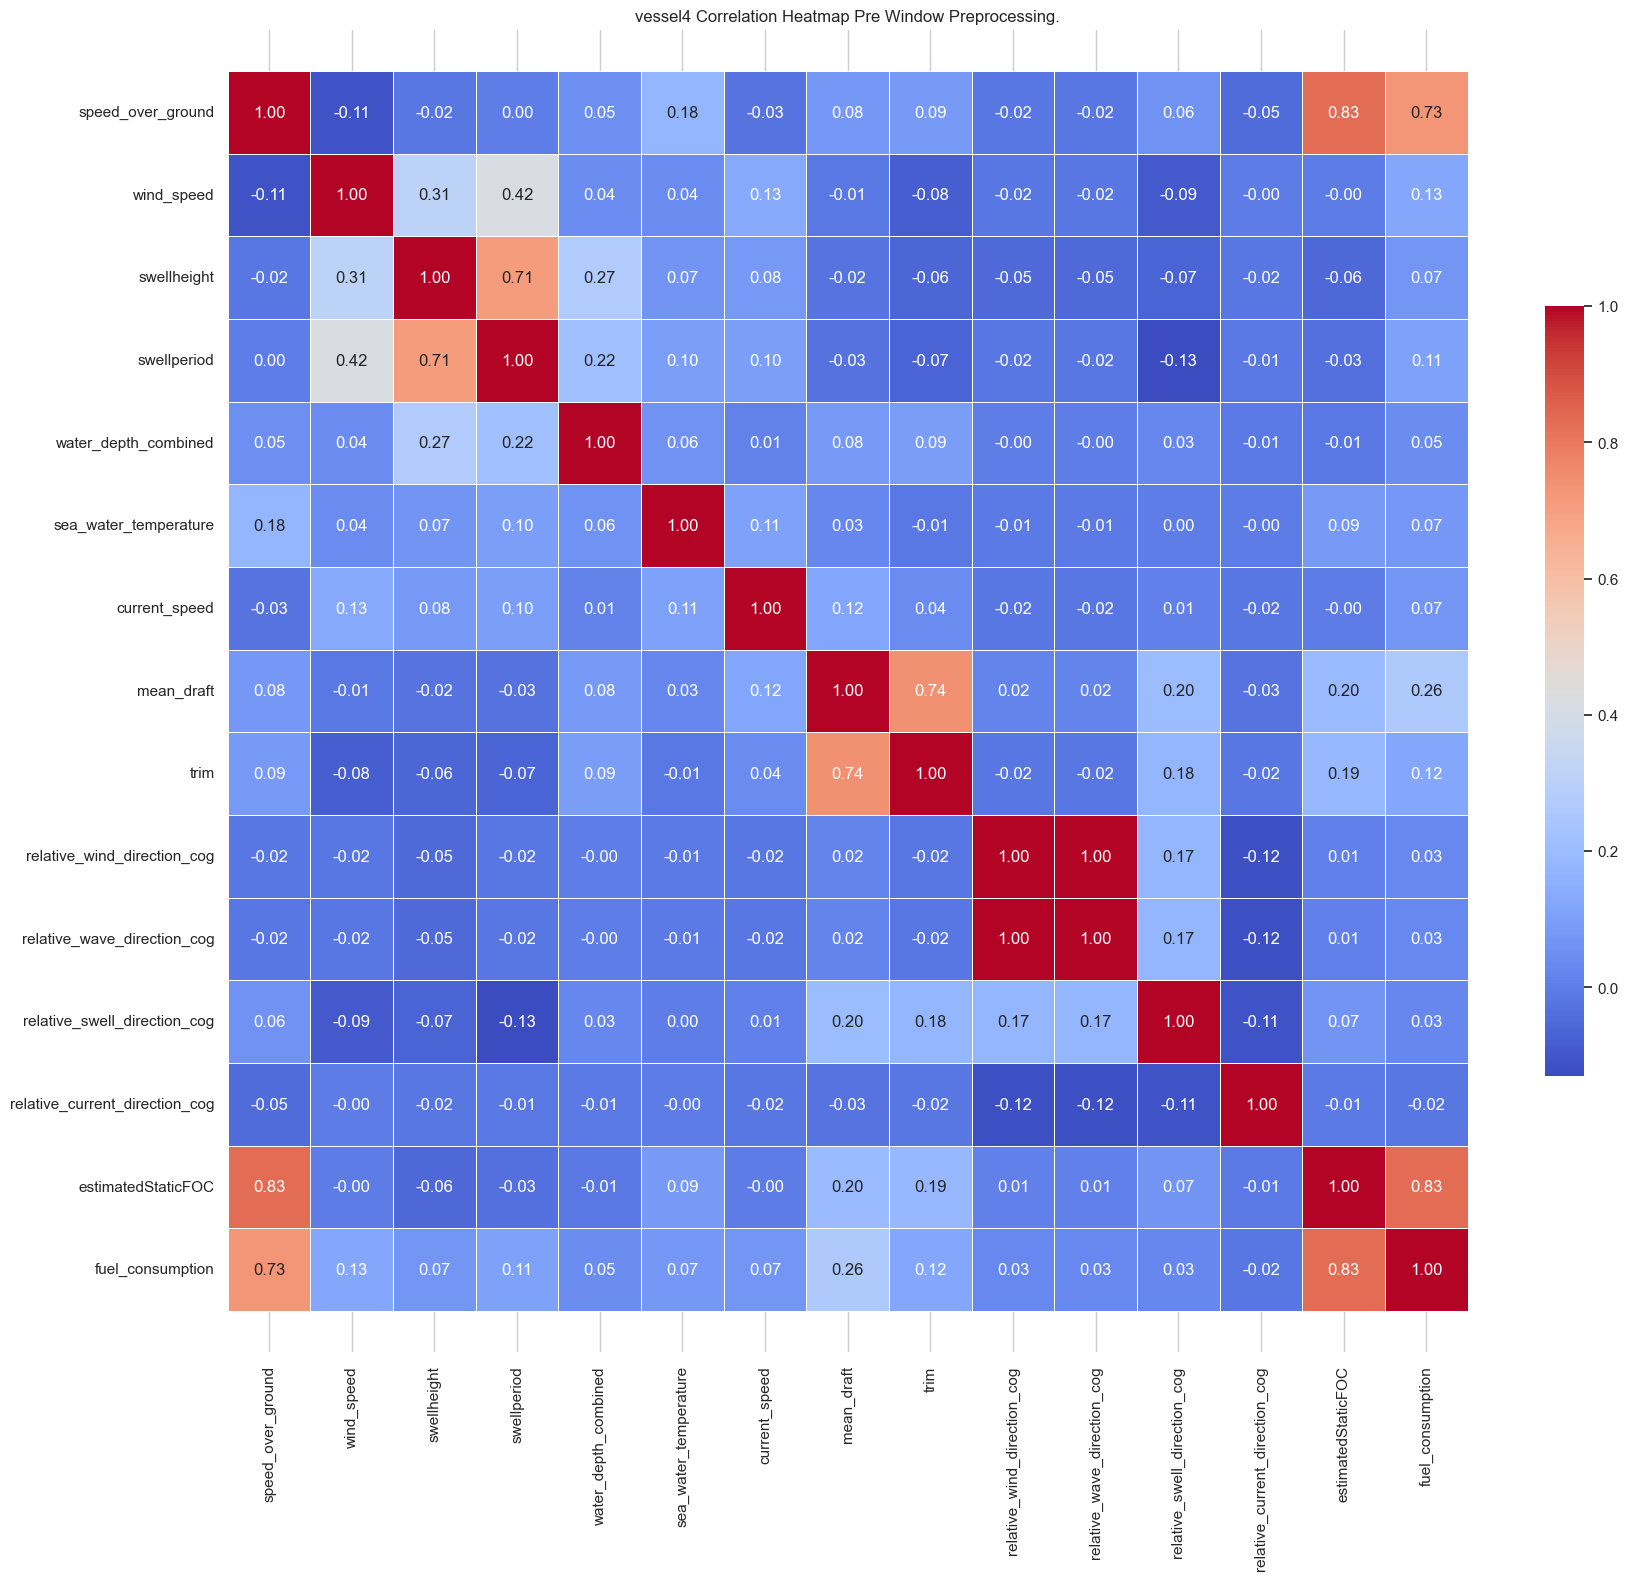

In [167]:

reorder_cols = [
    'speed_over_ground', 'wind_speed', 'swellheight', 'swellperiod', 'water_depth_combined', 
    'sea_water_temperature', 'current_speed', 'mean_draft', 'trim', 'relative_wind_direction_cog',
    'relative_wave_direction_cog', 'relative_swell_direction_cog', 'relative_current_direction_cog', 'estimatedStaticFOC',
    'fuel_consumption'
]

data_filtered_no_timestamps = vessel1_preprocessed[reorder_cols]


corr = data_filtered_no_timestamps.corr()


plt.figure(figsize=(20, 20))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title(f'vessel{vessel_num} Correlation Heatmap Pre Window Preprocessing.')

plt.ylim(len(corr)+0.5, -0.5)

plt.show()


In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#cleaned_data = data.dropna(subset=['power_consumption', 'fuel_consumption'])

if vessel_num == 1: 
    propulsion_power = vessel1_preprocessed['power_consumption']
    fuel_consumption = vessel1_preprocessed['fuel_consumption']

    X = sm.add_constant(propulsion_power)
    model = sm.OLS(fuel_consumption, X).fit()

    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    threshold = 4 / len(vessel1_preprocessed)

    outliers = cooks_d > threshold

if vessel_num == 7: 
    propulsion_power = vessel1_preprocessed['power_consumption']
    fuel_consumption = vessel1_preprocessed['fuel_consumption']

    X = sm.add_constant(propulsion_power)
    model = sm.OLS(fuel_consumption, X).fit()

    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    threshold = 2 / len(vessel1_preprocessed)

    outliers = cooks_d > threshold

if vessel_num == 5: 
    propulsion_power = vessel1_preprocessed['power_consumption']
    fuel_consumption = vessel1_preprocessed['fuel_consumption']

    X = sm.add_constant(propulsion_power)
    model = sm.OLS(fuel_consumption, X).fit()

    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    threshold = 3 / len(vessel1_preprocessed)

    outliers = cooks_d > threshold

if vessel_num == 4: 
    propulsion_power = vessel1_preprocessed['power_consumption']
    fuel_consumption = vessel1_preprocessed['fuel_consumption']

    X = sm.add_constant(propulsion_power)
    model = sm.OLS(fuel_consumption, X).fit()

    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]

    threshold =3 / len(vessel1_preprocessed)

    outliers = cooks_d > threshold


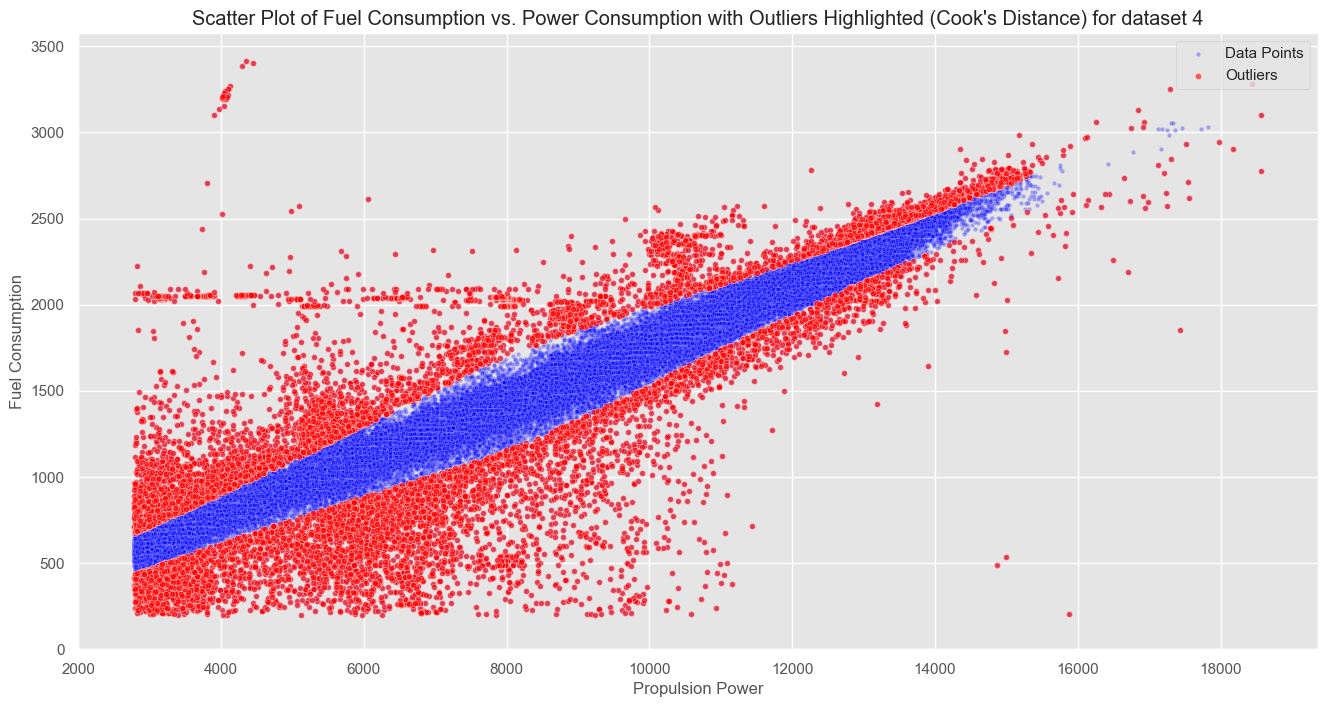

In [173]:
plt.style.use('ggplot')

plt.figure(figsize=(16, 8))

sns.scatterplot(x=propulsion_power, y=fuel_consumption, label='Data Points', s=10, alpha=0.3, color='blue')

sns.scatterplot(x=propulsion_power[outliers], y=fuel_consumption[outliers], label='Outliers', color='red', s=20, marker='o', alpha=0.6)

plt.title(f'Scatter Plot of Fuel Consumption vs. Power Consumption with Outliers Highlighted (Cook\'s Distance) for dataset {vessel_num}')
plt.xlabel('Propulsion Power')
plt.ylabel('Fuel Consumption')

plt.ylim(bottom=0)

plt.legend(loc='upper right')

plt.show()

In [139]:
vessel1_preprocessed = vessel1_preprocessed.loc[~outliers].reset_index(drop=True)

In [140]:
len(vessel1_preprocessed)

107993

Quasi steady state filtering, first will try to find acceleration / deaccelerations by 2 hour windows, and the second will try to find drifting in the dataset. 

This is the original one which should be part of the preprocessing framework. This approach was based on my own intuition of analyzing the linear regression with the residuals. It does not directly follow the papers algorithm. 

For my model you first run this to catch 2hour windows possibly acceleration/deacceleration. 

In [141]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t

vessel1_preprocessed['timestamp'] = pd.to_datetime(vessel1_preprocessed['timestamp'])
vessel1_preprocessed.set_index('timestamp', inplace=True)

window_size = '2H' 
vessel1_preprocessed['t_value'] = np.nan
vessel1_preprocessed['steady_state'] = 0

for window in vessel1_preprocessed.rolling(window=window_size):
    if len(window) < 2:
        continue  # skip windows with less than 2 data points

    time_seconds = (window.index - window.index[0]).total_seconds().values

    X = sm.add_constant(time_seconds.reshape(-1, 1))
    y = window['speed_over_ground'].values

    model = sm.OLS(y, X)
    results = model.fit()

    beta_hat = results.params[1]  # slope of the regression
    residuals = results.resid  # residuals of the model
    sigma_hat = np.std(residuals)  # standard deviation of residuals

    t_value = beta_hat / (sigma_hat + 1)

    vessel1_preprocessed.loc[window.index[-1], 't_value'] = t_value

    degrees_of_freedom = len(window) - 2

    critical_t = t.ppf(1 - 0.01 / 2, df=degrees_of_freedom)

    if abs(t_value) < critical_t:
        vessel1_preprocessed.loc[window.index, 'steady_state'] = 1


vessel1_preprocessed.reset_index(inplace=True)

/tmp/ipykernel_5454/1129419516.py:13: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [142]:
steady = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 1]

len(steady)

107922

This plot just to understand what values were find as unsteady based on 2 hour window. 

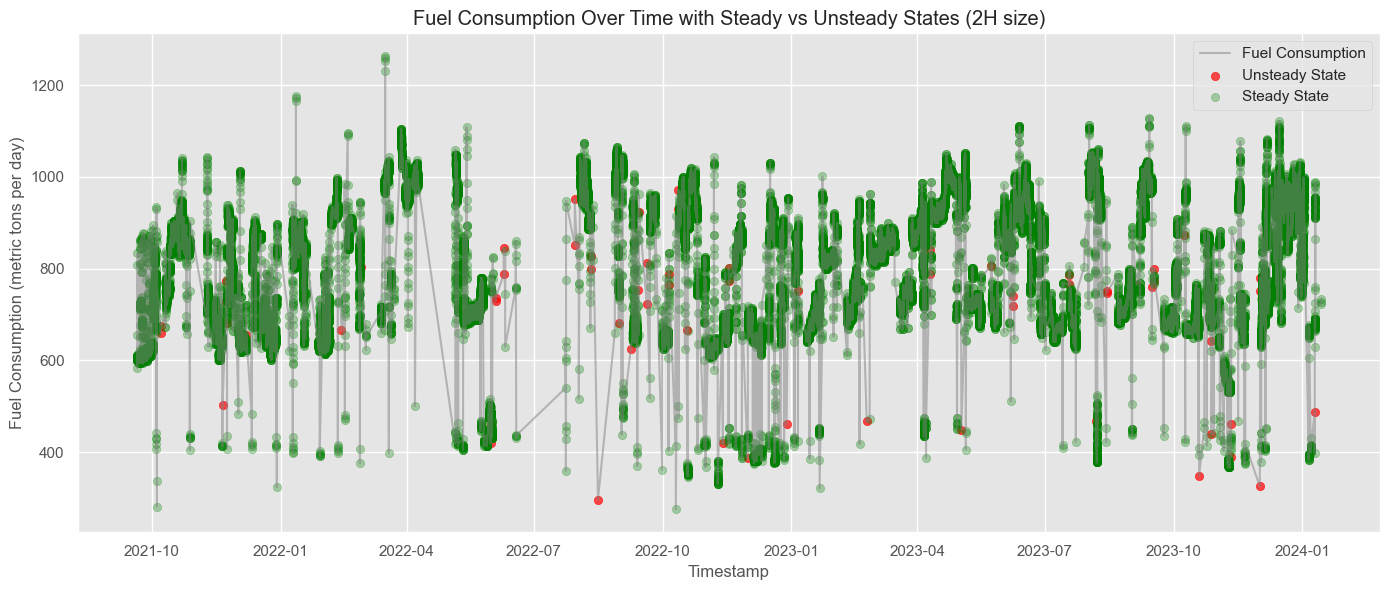

In [143]:
def visualize_static(vessel1_preprocessed):
    plt.figure(figsize=(14, 6))

    plt.plot(vessel1_preprocessed['timestamp'], vessel1_preprocessed['fuel_consumption'], label='Fuel Consumption', color='grey', alpha=0.5)

    unsteady_records = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 0]
    plt.scatter(unsteady_records['timestamp'], unsteady_records['fuel_consumption'], color='red', label='Unsteady State', alpha=0.7)

    steady_records = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 1]
    plt.scatter(steady_records['timestamp'], steady_records['fuel_consumption'], color='green', label='Steady State', alpha=0.3)

    plt.title(f'Fuel Consumption Over Time with Steady vs Unsteady States ({window_size} size)')
    plt.xlabel('Timestamp')
    plt.ylabel('Fuel Consumption (metric tons per day)')
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'vessel{vessel_num}{window_size}.png')

    plt.show()

visualize_static(vessel1_preprocessed)

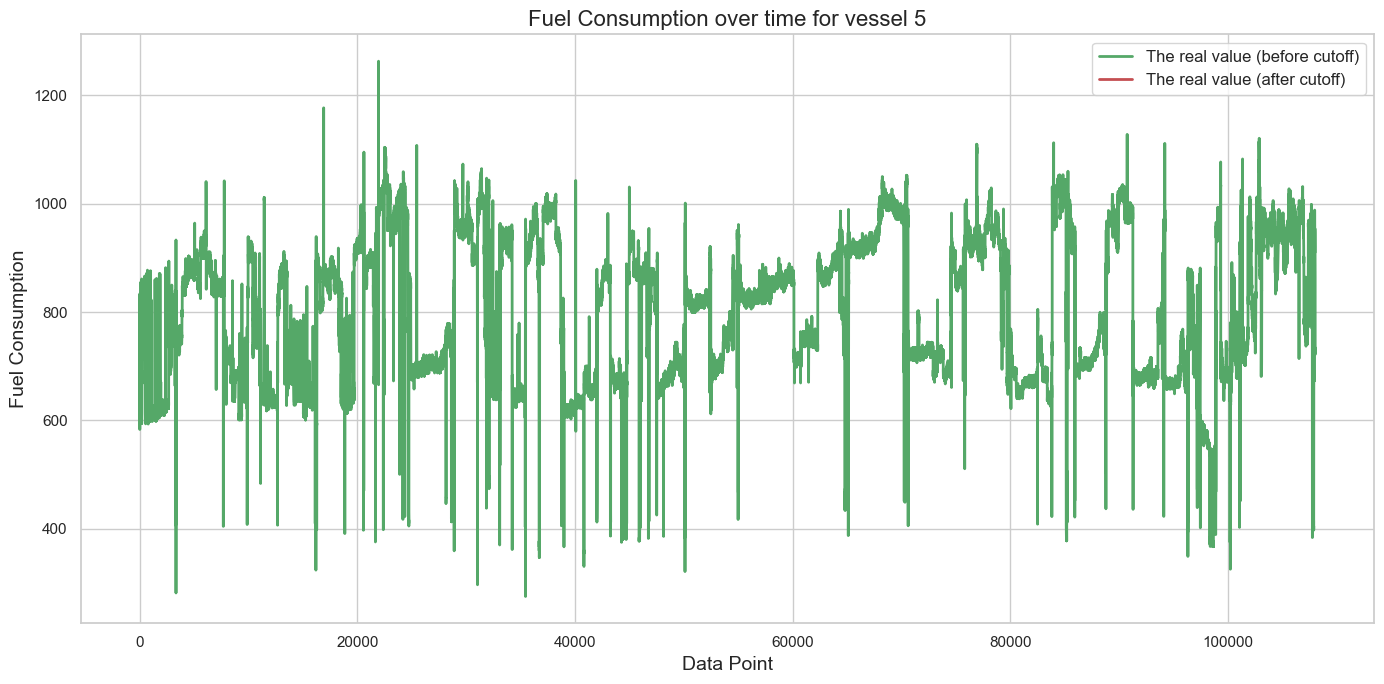

In [144]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))

cutoff = 369000
plt.plot(vessel1_preprocessed.index[vessel1_preprocessed.index <= cutoff], vessel1_preprocessed['fuel_consumption'][vessel1_preprocessed.index <= cutoff], 'g-', label='The real value (before cutoff)', linewidth=2)
plt.plot(vessel1_preprocessed.index[vessel1_preprocessed.index > cutoff], vessel1_preprocessed['fuel_consumption'][vessel1_preprocessed.index > cutoff], 'r-', label='The real value (after cutoff)', linewidth=2)

plt.title(f'Fuel Consumption over time for vessel {vessel_num}', fontsize=16)
plt.xlabel('Data Point', fontsize=14)
plt.ylabel('Fuel Consumption', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.show()

This one is catches drifting of the dataset, analyzes higher windows should also be part of the preprocessing after running the first step

In [145]:
remove_non_steady_data = vessel1_preprocessed.copy()

remove_non_steady_data['timestamp'] = pd.to_datetime(remove_non_steady_data['timestamp'])

window_size = 600  
remove_non_steady_data['t_value'] = np.nan
remove_non_steady_data['steady_state'] = 0

for i in range(len(remove_non_steady_data) - window_size + 1):
    window = remove_non_steady_data.iloc[i:i + window_size]
    
    time_seconds = (window['timestamp'] - window['timestamp'].iloc[0]).dt.total_seconds().values.reshape(-1, 1)
    y = window['speed_over_ground'].values

    X = sm.add_constant(time_seconds)
    
    model = sm.OLS(y, X).fit()

    beta_hat = model.params[1]  # slope of the regression
    sigma_beta_hat = model.bse[1]  # standard error of the slope estimate

    t_value = beta_hat / (sigma_beta_hat + 1)

    remove_non_steady_data.loc[i + window_size - 1, 't_value'] = t_value

    degrees_of_freedom = window_size - 2
    critical_t = t.ppf(1 - 0.01 / 2, df=degrees_of_freedom)

    if abs(t_value) < critical_t:
        remove_non_steady_data.loc[i + window_size - 1, 'steady_state'] = 1

remove_non_steady_data.set_index('timestamp', inplace=True)

In [146]:
remove_non_steady_data.reset_index(inplace=True)

vessel1_preprocessed = remove_non_steady_data.copy()


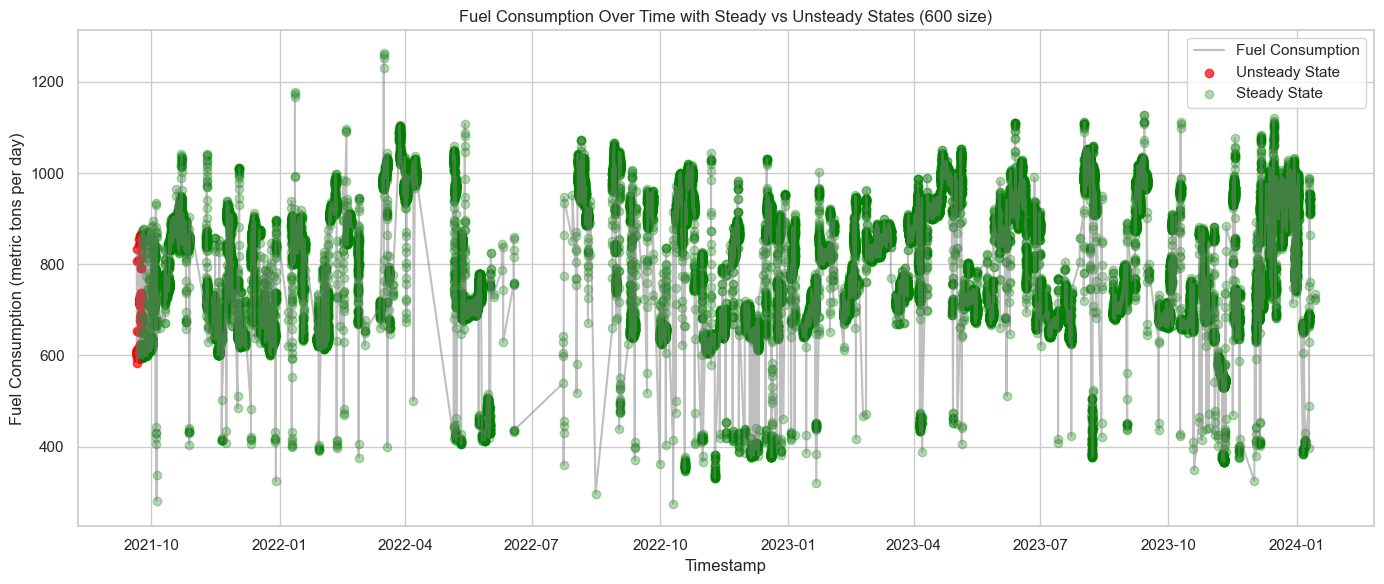

In [147]:
visualize_static(vessel1_preprocessed)

Next algorithms, are following the papers instructions more indepth and should possibly used to improve the previous algorithms. These should not be part of the preprocessing as they still missclassify alot of the datapoints, maybe code issues or because the speed is just really noisy. 

In [21]:
vessel1_preprocessed['timestamp'] = pd.to_datetime(vessel1_preprocessed['timestamp'])
vessel1_preprocessed.set_index('timestamp', inplace=True)

window_size = 12
vessel1_preprocessed['t_value'] = np.nan
vessel1_preprocessed['steady_state'] = 0

for window in vessel1_preprocessed.rolling(window=window_size):
    if len(window) < 2:
        continue 

    time_seconds = (window.index - window.index[0]).total_seconds().values

    X = sm.add_constant(time_seconds.reshape(-1, 1))
    y = window['speed_over_ground'].values

    model = sm.OLS(y, X)
    results = model.fit()

    beta_hat = results.params[1] 

    sigma_hat=results.bse[1]
    
    t_value = beta_hat / (sigma_hat+1)


    vessel1_preprocessed.loc[window.index[-1], 't_value'] = t_value

    degrees_of_freedom = len(window) - 2  
    
    critical_t = t.ppf(0.9 / 2, df=degrees_of_freedom) 
    #print(f"Beta_Hat = {beta_hat} / Sigma_HAT = {sigma_hat} == Tvalue:  {t_value} ====> critical {critical_t}")

    steady_state_value = 1 if abs(t_value) <= critical_t else 0

    vessel1_preprocessed.loc[window.index, 't_value'] = t_value
    vessel1_preprocessed.loc[window.index, 'steady_state'] = steady_state_value


vessel1_preprocessed.reset_index(inplace=True)

/home/borna/Desktop/ship_performance/env/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


EXPERIMENT 2, ADDING OVERLAPPING WINDOWS (Still results in poor performance, missclassifying points)

In [ ]:
vessel1_preprocessed['timestamp'] = pd.to_datetime(vessel1_preprocessed['timestamp'])
vessel1_preprocessed.set_index('timestamp', inplace=True)

window_size = "2h"
significance_level = 0.50

vessel1_preprocessed['t_value'] = np.nan
vessel1_preprocessed['steady_state'] = np.nan

rolling_window = vessel1_preprocessed.rolling(window_size)

for time_point in rolling_window:
    if len(time_point) < 2:
        continue

    time_seconds = (time_point.index - time_point.index[0]).total_seconds().values
    X = sm.add_constant(time_seconds.reshape(-1, 1))
    y = time_point['speed_over_ground'].values

    model = sm.OLS(y, X)
    results = model.fit()

    beta_hat = results.params[1]
    sigma_hat = results.bse[1]
    
    t_value = beta_hat / sigma_hat
    
    degrees_of_freedom = len(time_point) - 2
    critical_t = t.ppf(1 - significance_level / 2, df=degrees_of_freedom)

    steady_state_value = 1 if abs(t_value) <= critical_t else 0
    print(f"Time Point: {time_point.index[-1]}")
    print(f"Beta_Hat: {beta_hat}, Sigma_Hat: {sigma_hat}, T_Value: {t_value}, Critical_T: {critical_t}, Steady_State: {steady_state_value}")

    vessel1_preprocessed.loc[time_point.index, 't_value'] = t_value
    vessel1_preprocessed.loc[time_point.index, 'steady_state'] = steady_state_value

vessel1_preprocessed.reset_index(inplace=True)



In this experiment, I tried only setting windows with top 5% t-values  as unsteady.

In [24]:
vessel1_preprocessed['timestamp'] = pd.to_datetime(vessel1_preprocessed['timestamp'])
vessel1_preprocessed.set_index('timestamp', inplace=True)

window_size = 3
vessel1_preprocessed['t_value'] = np.nan
vessel1_preprocessed['steady_state'] = 0

for start in range(len(vessel1_preprocessed) - window_size + 1):
    window = vessel1_preprocessed.iloc[start:start + window_size]

    if len(window) < 2:
        continue

    time_seconds = (window.index - window.index[0]).total_seconds().values
    X = sm.add_constant(time_seconds.reshape(-1, 1))
    y = window['speed_over_ground'].values

    model = sm.OLS(y, X)
    results = model.fit()

    beta_hat = results.params[1]  # slope of the regression
    sigma_hat = results.bse[1]    # standard error of the slope

    t_value = beta_hat / (sigma_hat + 1)

    vessel1_preprocessed.loc[window.index[-1], 't_value'] = t_value

degrees_of_freedom = window_size
critical_t = t.ppf(1 - 0.01 / 2, df=degrees_of_freedom)

top_5_percent_threshold = vessel1_preprocessed['t_value'].abs().quantile(0.95)

vessel1_preprocessed['steady_state'] = (vessel1_preprocessed['t_value'].abs() <= critical_t).astype(int)

vessel1_preprocessed.loc[vessel1_preprocessed['t_value'].abs() > top_5_percent_threshold, 'steady_state'] = 0

vessel1_preprocessed.reset_index(inplace=True)

significant_spikes = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 0]


Experiment with Smoothing

In this experiment I tried to use savgol filter to smoothen out the data to find trends more clearly and then running the quasi steady state filter. 

- +1 denominator 
- top 5%, parameters. 
- tried RPM, 
- 

In [ ]:


vessel1_preprocessed['timestamp'] = pd.to_datetime(vessel1_preprocessed['timestamp'])
vessel1_preprocessed.set_index('timestamp', inplace=True)

smoothing_window_size = 30  
poly_order = 2  
vessel1_preprocessed['smoothed_speed'] = savgol_filter(vessel1_preprocessed['speed_over_ground'], smoothing_window_size, poly_order)

regression_window_size = 8  
significance_level = 0.01  
vessel1_preprocessed['t_value'] = np.nan
vessel1_preprocessed['steady_state'] = np.nan

for start in range(len(vessel1_preprocessed) - regression_window_size + 1):
    window = vessel1_preprocessed.iloc[start:start + regression_window_size]

    time_seconds = (window.index - window.index[0]).total_seconds().values
    X = sm.add_constant(time_seconds.reshape(-1, 1))
    y = window['smoothed_speed'].values

    model = sm.OLS(y, X)
    results = model.fit()

    beta_hat = results.params[1]
    sigma_hat = results.bse[1]
    t_value = beta_hat / (sigma_hat + 1) 
    degrees_of_freedom = len(window) - 2
    
    critical_t = t.ppf(1 - significance_level / 2, df=degrees_of_freedom)  

    steady_state_value = 1 if abs(t_value) <= critical_t else 0

    print(f"FOR LOOP: {start}")
    print(f"BETA HAT: {beta_hat}")
    print(f"SIGMA HAT: {sigma_hat}")
    print(f"T VALUE: {t_value}")
    print(f"degrees_of_freedom: {degrees_of_freedom}")
    print(f"critical_t: {critical_t}")
    print(f"steady_state_value: {steady_state_value}")
    print(f"Window Index Range: {window.index}")

    vessel1_preprocessed.loc[window.index, 't_value'] = t_value
    vessel1_preprocessed.loc[window.index, 'steady_state'] = steady_state_value  

vessel1_preprocessed.reset_index(inplace=True)



Here you can visualize the results after the algorithm has been ran, and zoom into datapoints to see more clearly what kind of datapoints were detected as unsteady. 

In [ ]:
vessel1_preprocessed['timestamp'] = pd.to_datetime(vessel1_preprocessed['timestamp'])

vessel1_preprocessed_2020 = vessel1_preprocessed[vessel1_preprocessed['timestamp'].dt.year == 2018]

line_trace = go.Scatter(
    x=vessel1_preprocessed_2020['timestamp'],
    y=vessel1_preprocessed_2020['speed_over_ground'],
    mode='lines',
    name='Fuel Consumption',
    line=dict(color='grey', width=2),
    opacity=0.5
)

unsteady_trace = go.Scatter(
    x=vessel1_preprocessed_2020[vessel1_preprocessed_2020['steady_state'] == 0]['timestamp'],
    y=vessel1_preprocessed_2020[vessel1_preprocessed_2020['steady_state'] == 0]['speed_over_ground'],
    mode='markers',
    name='Unsteady State',
    marker=dict(color='red', size=6),
    opacity=0.7
)

steady_trace = go.Scatter(
    x=vessel1_preprocessed_2020[vessel1_preprocessed_2020['steady_state'] == 1]['timestamp'],
    y=vessel1_preprocessed_2020[vessel1_preprocessed_2020['steady_state'] == 1]['speed_over_ground'],
    mode='markers',
    name='Steady State',
    marker=dict(color='green', size=6),
    opacity=0.3
)

layout = go.Layout(
    title=f'vessel{vessel_num} Speed Over Ground Over Time with Steady vs Unsteady States ({window_size} size)',
    xaxis_title='Timestamp',
    yaxis_title='Speed Over Ground',
    legend_title='Legend',
    width=1400,
    height=600
)

fig = go.Figure(data=[line_trace, unsteady_trace, steady_trace], layout=layout)

fig.show()


Next section is some statistics about the steady / unsteady data. 

In [46]:
non_steady_data = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 0]
steady_data = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 1]

print(f"Non-steady data points: {len(non_steady_data)}")
print(f"Steady data points: {len(steady_data)}")

total_points = len(vessel1_preprocessed)
non_steady_ratio = len(non_steady_data) / total_points
steady_ratio = len(steady_data) / total_points

print(f"Proportion of non-steady data points: {non_steady_ratio:.2%}")
print(f"Proportion of steady data points: {steady_ratio:.2%}")

(325336, 38931)

In [20]:
steady_summary = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 1].describe()
unsteady_summary = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 0].describe()

steady_summary

timestamp  speed_through_water  speed_over_ground  \
count                         345132        345132.000000      345132.000000   
mean   2020-03-29 22:49:05.244427776             8.867328           8.798506   
min              2017-04-11 22:50:00             3.000458           3.095146   
25%              2018-10-15 15:08:45             8.235552           8.181034   
50%              2020-02-07 14:32:30             8.923470           8.825833   
75%              2021-09-10 00:01:15             9.624969           9.488254   
max              2023-05-24 08:45:00            11.795462          12.341105   
std                              NaN             1.017522           0.926813   

             heading  course_over_ground  power_consumption            rpm  \
count  345132.000000        3.451320e+05      345132.000000  345132.000000   
mean      148.425786        1.483722e+02        8044.017467      82.365431   
min         0.000680        4.760986e-07        2210.882353      46.509524   
25%        61.485643        6.050782e+01        6087.269195      76.030303   
50%       125.510795        1.281411e+02        7997.404910      83.120000   
75%       240.021368        2.393167e+02       10001.448980      89.554021   
max       359.998282        3.599997e+02       14678.429185     102.752273   
std        94.350117        9.477641e+01        2334.648223       8.146288   

           draft_aft      draft_fwd  fuel_consumption  ...  fuel_per_power  \
count  345132.000000  345132.000000     345132.000000  ...   345132.000000   
mean        8.665934       8.050052       1494.581988  ...        0.187252   
min         5.350000       4.800000        200.043703  ...        0.018714   
25%         7.900000       6.700000       1143.329454  ...        0.182509   
50%         8.900000       8.600000       1495.786648  ...        0.186714   
75%         9.500000       9.200000       1850.723264  ...        0.192617   
max        12.000000      12.000000       3859.769862  ...        0.605097   
std         1.011012       1.321486        420.221909  ...        0.017840   

       water_depth_combined     mean_draft           trim  \
count         345132.000000  345132.000000  345132.000000   
mean            2978.420477       8.357993      -0.615882   
min              -75.458380       5.800000      -2.730000   
25%             1092.153869       7.275000      -0.900000   
50%             3310.448211       8.800000      -0.500000   
75%             4600.363559       9.350000      -0.150000   
max             8979.352914      12.000000       2.050000   
std             1995.248760       1.131487       0.644896   

       relative_wind_direction_cog  relative_wave_direction_cog  \
count                345132.000000                345132.000000   
mean                    176.312452                   176.312452   
min                       0.000890                     0.000890   
25%                     110.531419                   110.531419   
50%                     180.892893                   180.892893   
75%                     233.318428                   233.318428   
max                     359.997903                   359.997903   
std                      85.937757                    85.937757   

       relative_swell_direction_cog  relative_current_direction_cog  \
count                 345132.000000                   345132.000000   
mean                     171.459216                      176.997555   
min                        0.001261                        0.000939   
25%                       74.563886                       83.764678   
50%                      181.191136                      178.465818   
75%                      250.483164                      265.688524   
max                      359.999532                      359.999743   
std                      102.747789                      105.331670   

            t_value  steady_state  
count  3.451320e+05      345132.0  
mean  -2.161493e-07           1.0 

In [21]:
unsteady_summary

timestamp  speed_through_water  speed_over_ground  \
count                          19163         19163.000000       19163.000000   
mean   2019-11-28 07:13:47.422637312             8.155010           8.074771   
min              2017-04-11 22:40:00             3.004211           2.546845   
25%              2018-06-05 14:57:30             7.174231           7.106222   
50%              2019-08-09 09:05:00             8.305095           8.202982   
75%              2021-03-29 14:37:30             9.261120           9.132598   
max              2023-05-19 10:35:00            11.332239          12.558831   
std                              NaN             1.475713           1.449640   

            heading  course_over_ground  power_consumption           rpm  \
count  19163.000000        19163.000000       19163.000000  19163.000000   
mean     168.874492          169.168470        6500.309607     75.759282   
min        0.000331            0.001328        2210.742063     41.425758   
25%       76.694002           76.360539        4492.735362     68.119468   
50%      180.638716          180.194464        6198.149798     75.977444   
75%      249.944268          249.599816        8532.782568     85.010606   
max      359.996419          359.980918       14734.635628    103.176299   
std       96.804132           96.991529        2617.091616     11.339652   

          draft_aft     draft_fwd  fuel_consumption  ...  fuel_per_power  \
count  19163.000000  19163.000000      19163.000000  ...    19163.000000   
mean       8.452029      7.829181       1219.165944  ...        0.192024   
min        5.350000      4.800000        200.078570  ...        0.017995   
25%        7.600000      6.650000        885.955559  ...        0.180576   
50%        8.530000      7.950000       1172.646257  ...        0.189541   
75%        9.300000      9.100000       1561.355002  ...        0.202216   
max       12.000000     12.000000       3762.990487  ...        0.577287   
std        0.997886      1.317146        461.295324  ...        0.032905   

       water_depth_combined    mean_draft          trim  \
count          19163.000000  19163.000000  19163.000000   
mean            1450.132722      8.140605     -0.622849   
min              -85.808144      5.800000     -2.730000   
25%               26.653077      7.150000     -1.000000   
50%              149.368257      8.200000     -0.500000   
75%             2947.891645      9.200000     -0.100000   
max             8400.933144     12.000000      2.050000   
std             1932.156948      1.123131      0.644674   

       relative_wind_direction_cog  relative_wave_direction_cog  \
count                 19163.000000                 19163.000000   
mean                    179.281381                   179.281381   
min                       0.023838                     0.023838   
25%                     109.126408                   109.126408   
50%                     181.185090                   181.185090   
75%                     242.963157                   242.963157   
max                     359.927315                   359.927315   
std                      87.959563                    87.959563   

       relative_swell_direction_cog  relative_current_direction_cog  \
count                  19163.000000                    19163.000000   
mean                     173.318162                      173.203359   
min                        0.009757                        0.001660   
25%                       72.968525                       76.295418   
50%                      176.691468                      177.125255   
75%                      264.221050                      260.004541   
max                      359.993693                      359.999646   
std                      108.847286                      105.368144   

            t_value  steady_state  
count  18165.000000       19163.0  
mean       0.000225           0.0  
min       -0.003047           0.0  
25%       -0.000

# Making the final dataset include these into the preprocessing

In [148]:
steady_state_only = vessel1_preprocessed[vessel1_preprocessed['steady_state'] == 1]

columns_filtered = [
    'speed_over_ground', 'wind_speed', 'swellheight', 'swellperiod', 'water_depth_combined', 
    'sea_water_temperature', 'current_speed', 'mean_draft', 'trim', 'relative_wind_direction_cog',
    'relative_wave_direction_cog', 'relative_swell_direction_cog', 'relative_current_direction_cog', 'estimatedStaticFOC',
    'fuel_consumption'
]

steady_state_only_filtered = steady_state_only[columns_filtered]

steady_state_only_filtered_path = f'../../data/steady_state{vessel_num}.csv'
steady_state_only_filtered.to_csv(steady_state_only_filtered_path, index=False)

steady_state_only_filtered_path

'../../data/steady_state5.csv'

Final correlations

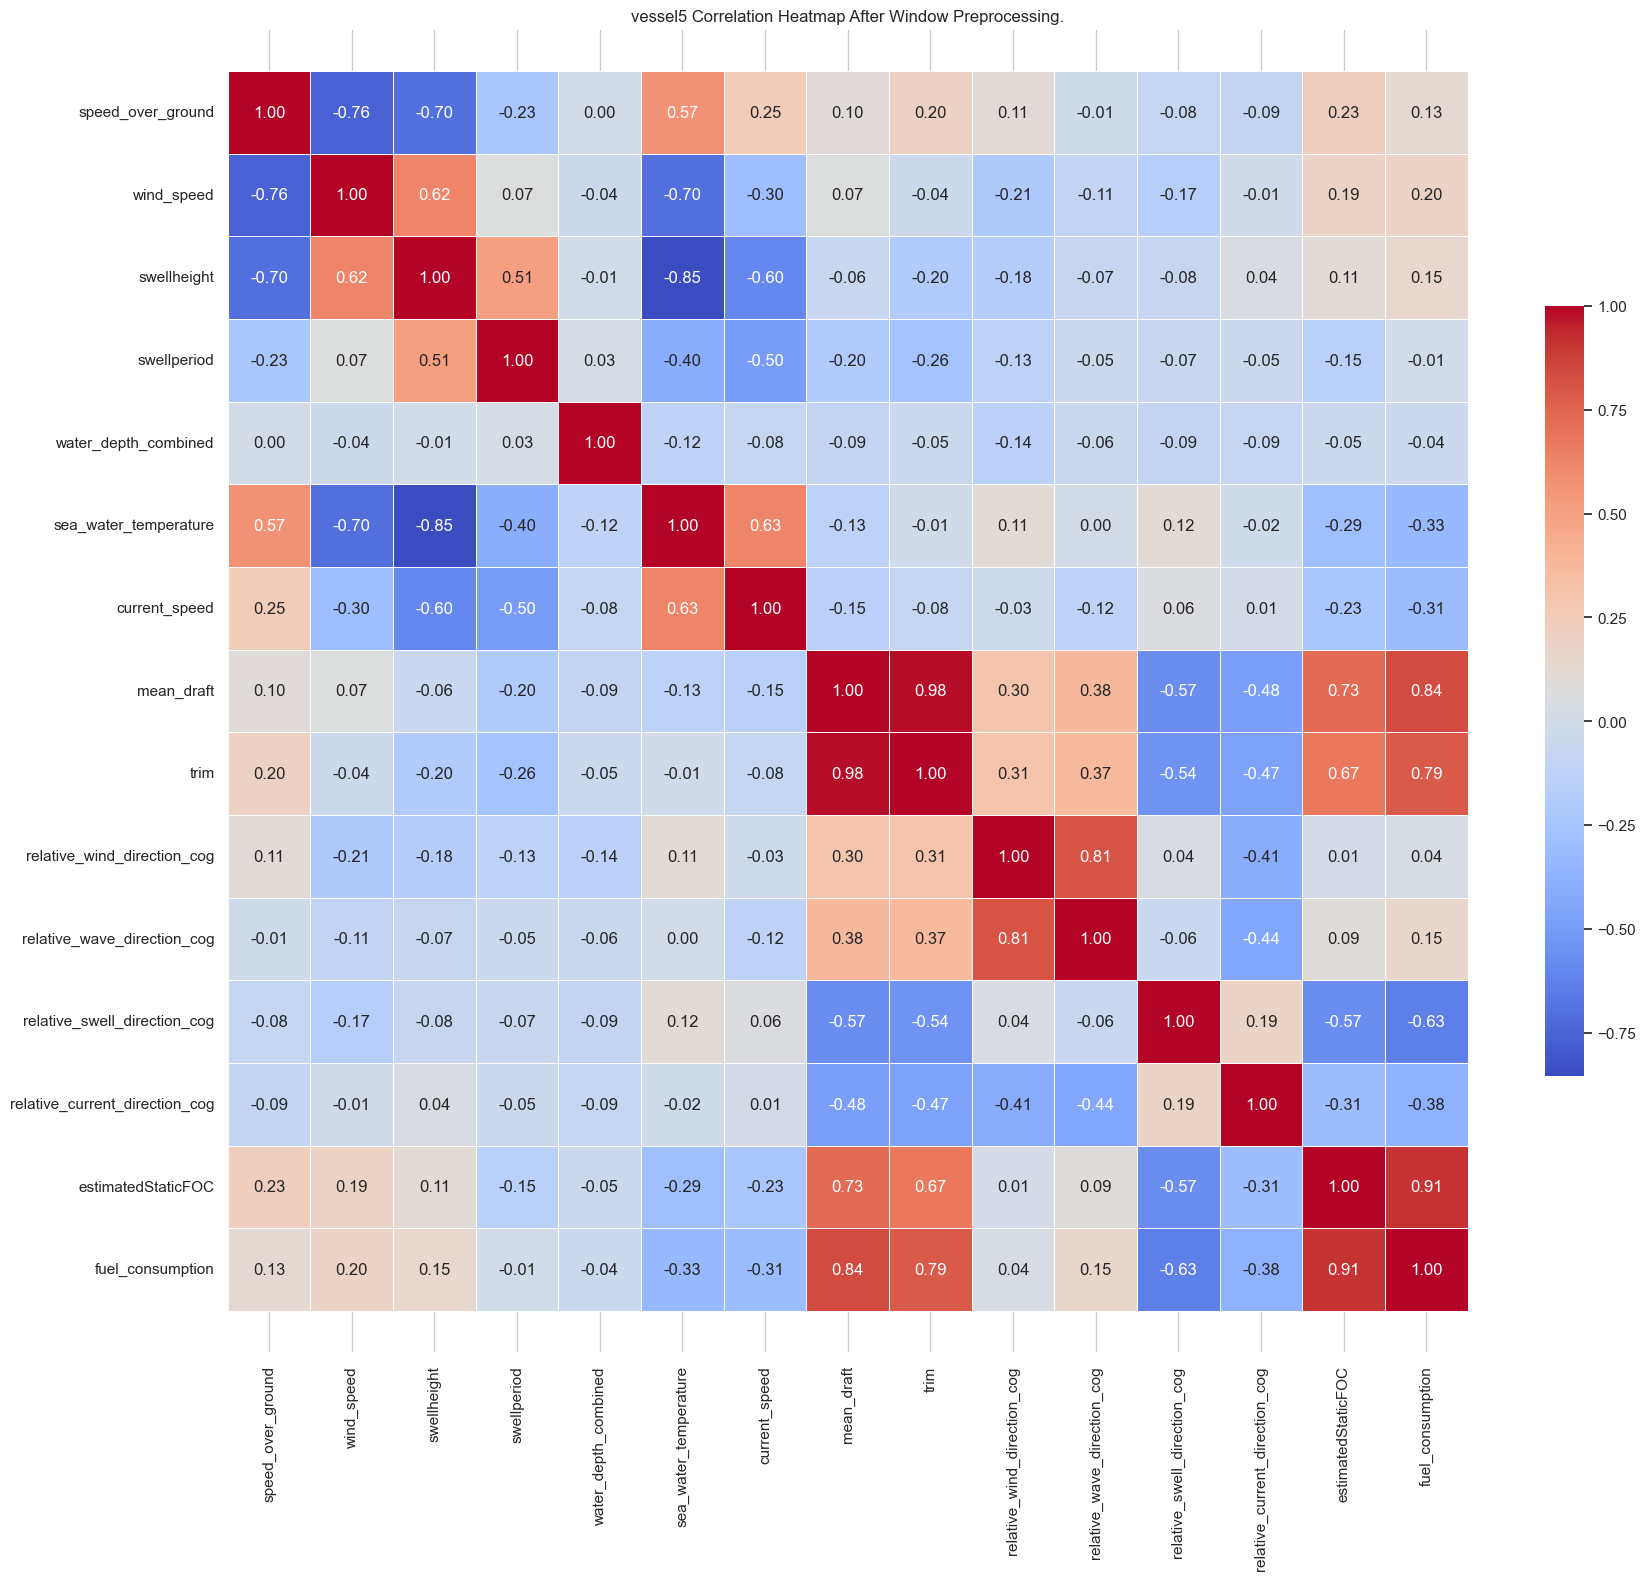

In [149]:

reorder_cols = [
    'speed_over_ground', 'wind_speed', 'swellheight', 'swellperiod', 'water_depth_combined', 
    'sea_water_temperature', 'current_speed', 'mean_draft', 'trim', 'relative_wind_direction_cog',
    'relative_wave_direction_cog', 'relative_swell_direction_cog', 'relative_current_direction_cog', 'estimatedStaticFOC',
    'fuel_consumption'
]

data_filtered_no_timestamps = steady_state_only_filtered.corr()


corr = data_filtered_no_timestamps.corr()


plt.figure(figsize=(20, 20))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title(f'vessel{vessel_num} Correlation Heatmap After Window Preprocessing.')

plt.ylim(len(corr)+0.5, -0.5)

plt.show()

Some extra visualizations... 

/tmp/ipykernel_5887/3788056230.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steady_state_only['timestamp'] = pd.to_datetime(steady_state_only['timestamp'])


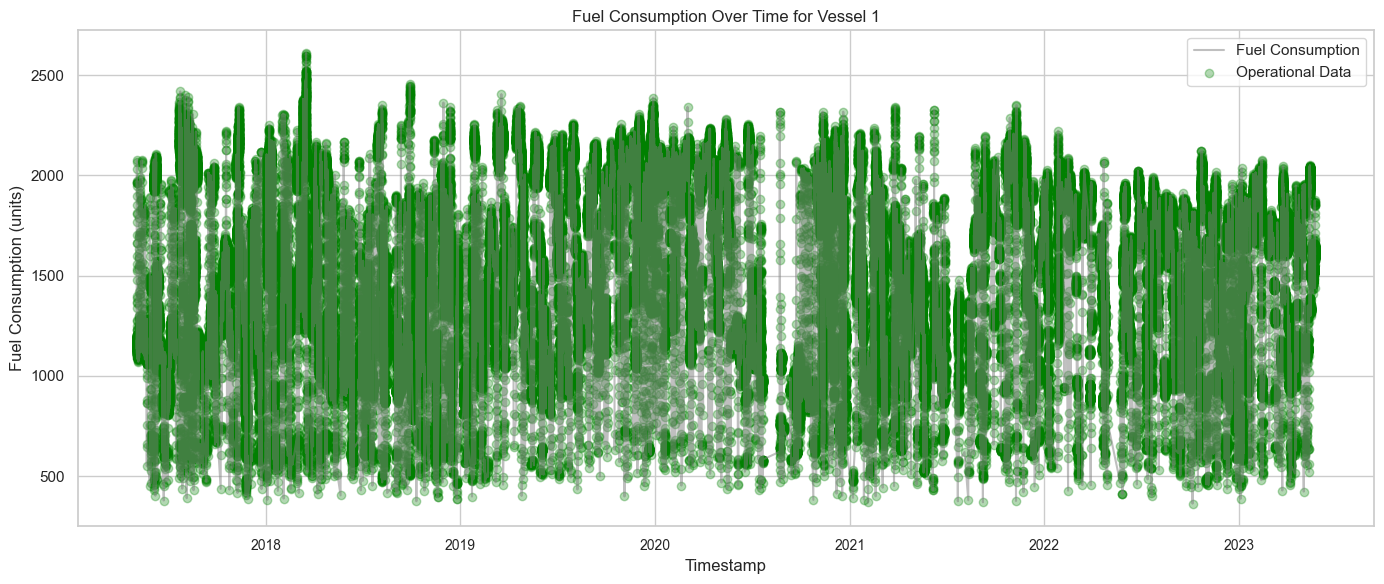

In [ ]:


steady_state_only['timestamp'] = pd.to_datetime(steady_state_only['timestamp'])


end_date = '2023-10-01'
steady_state_only = steady_state_only[steady_state_only['timestamp'] < end_date]

plt.figure(figsize=(14, 6))

plt.plot(steady_state_only['timestamp'], steady_state_only['fuel_consumption'], label='Fuel Consumption', color='grey', alpha=0.5)

plt.scatter(steady_state_only['timestamp'], steady_state_only['fuel_consumption'], color='green', label='Operational Data', alpha=0.3)

plt.title('Fuel Consumption Over Time for Vessel 1')
plt.xlabel('Timestamp')
plt.ylabel('Fuel Consumption (units)')
plt.legend()
plt.tight_layout()

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.gca().tick_params(axis='x', which='major', labelsize=10, rotation=0)

plt.show()


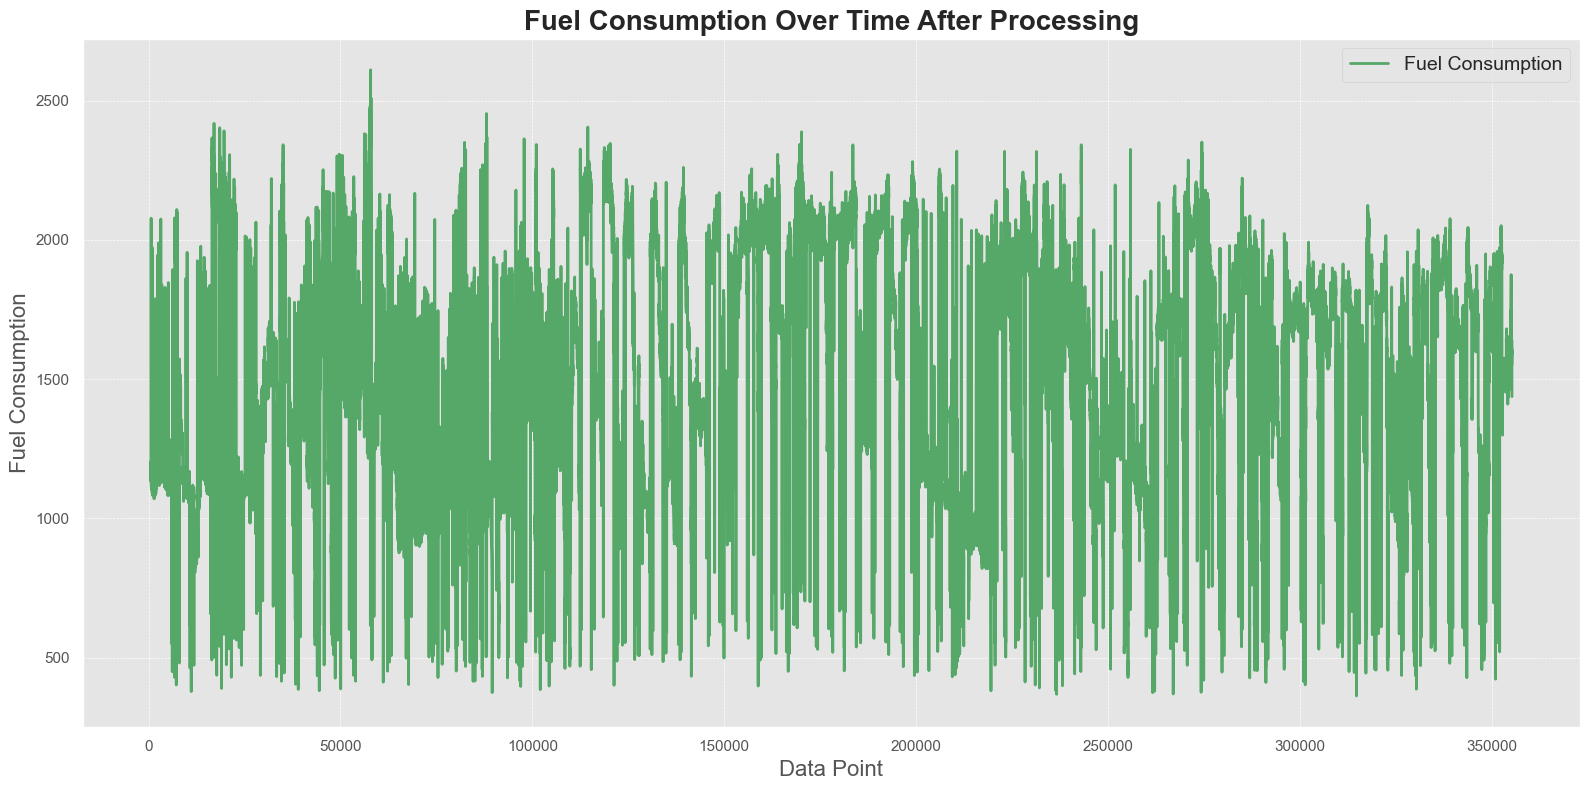

In [ ]:

plt.style.use('ggplot')
plt.figure(figsize=(16, 8))

plt.plot(steady_state_only.index, steady_state_only['fuel_consumption'], 'g-', label='Fuel Consumption', linewidth=2)

plt.title('Fuel Consumption Over Time After Processing', fontsize=20, fontweight='bold')
plt.xlabel('Data Point', fontsize=16)
plt.ylabel('Fuel Consumption', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()

plt.show()


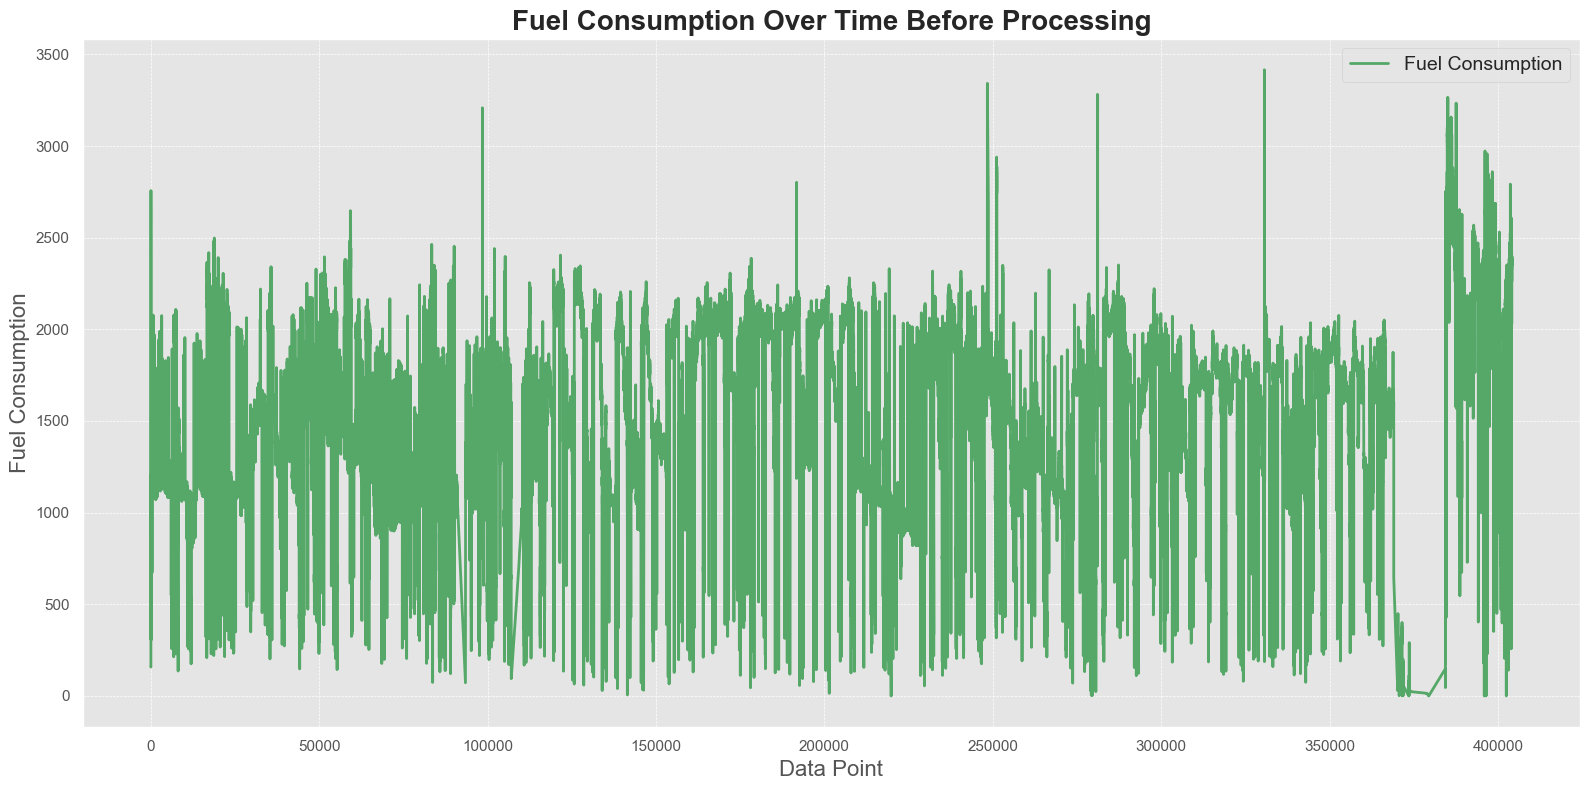

In [ ]:

plt.style.use('ggplot')
plt.figure(figsize=(16, 8))

plt.plot(vessel_1.index, vessel_1['fuel_consumption'], 'g-', label='Fuel Consumption', linewidth=2)

plt.title('Fuel Consumption Over Time Before Processing', fontsize=20, fontweight='bold')
plt.xlabel('Data Point', fontsize=16)
plt.ylabel('Fuel Consumption', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()

plt.show()

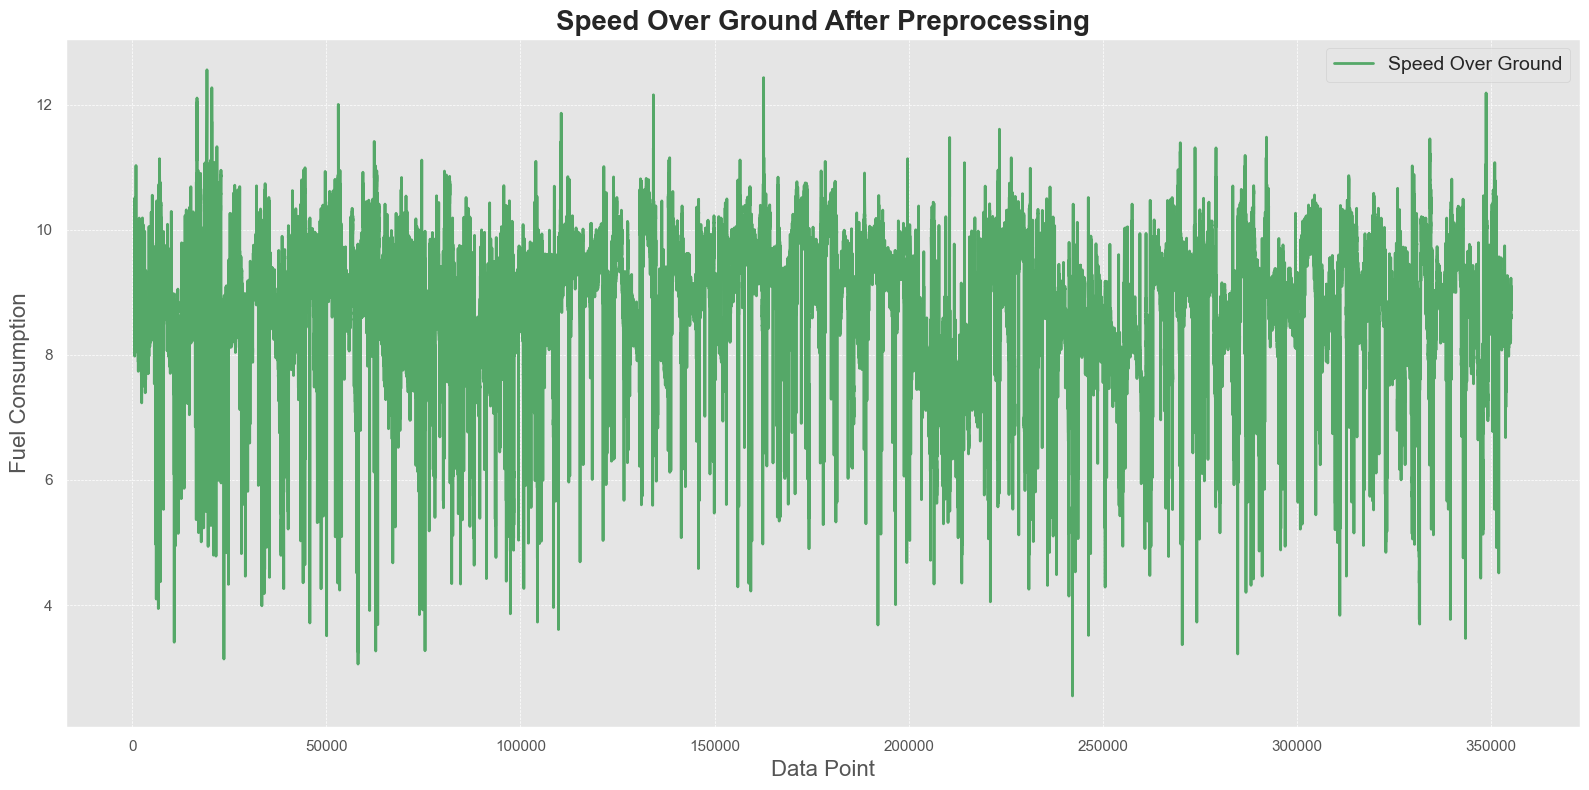

In [183]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(16, 8))

plt.plot(steady_state_only.index, steady_state_only['speed_over_ground'], 'g-', label='Speed Over Ground', linewidth=2)

plt.title('Speed Over Ground After Preprocessing', fontsize=20, fontweight='bold')
plt.xlabel('Data Point', fontsize=16)
plt.ylabel('Fuel Consumption', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()

plt.show()

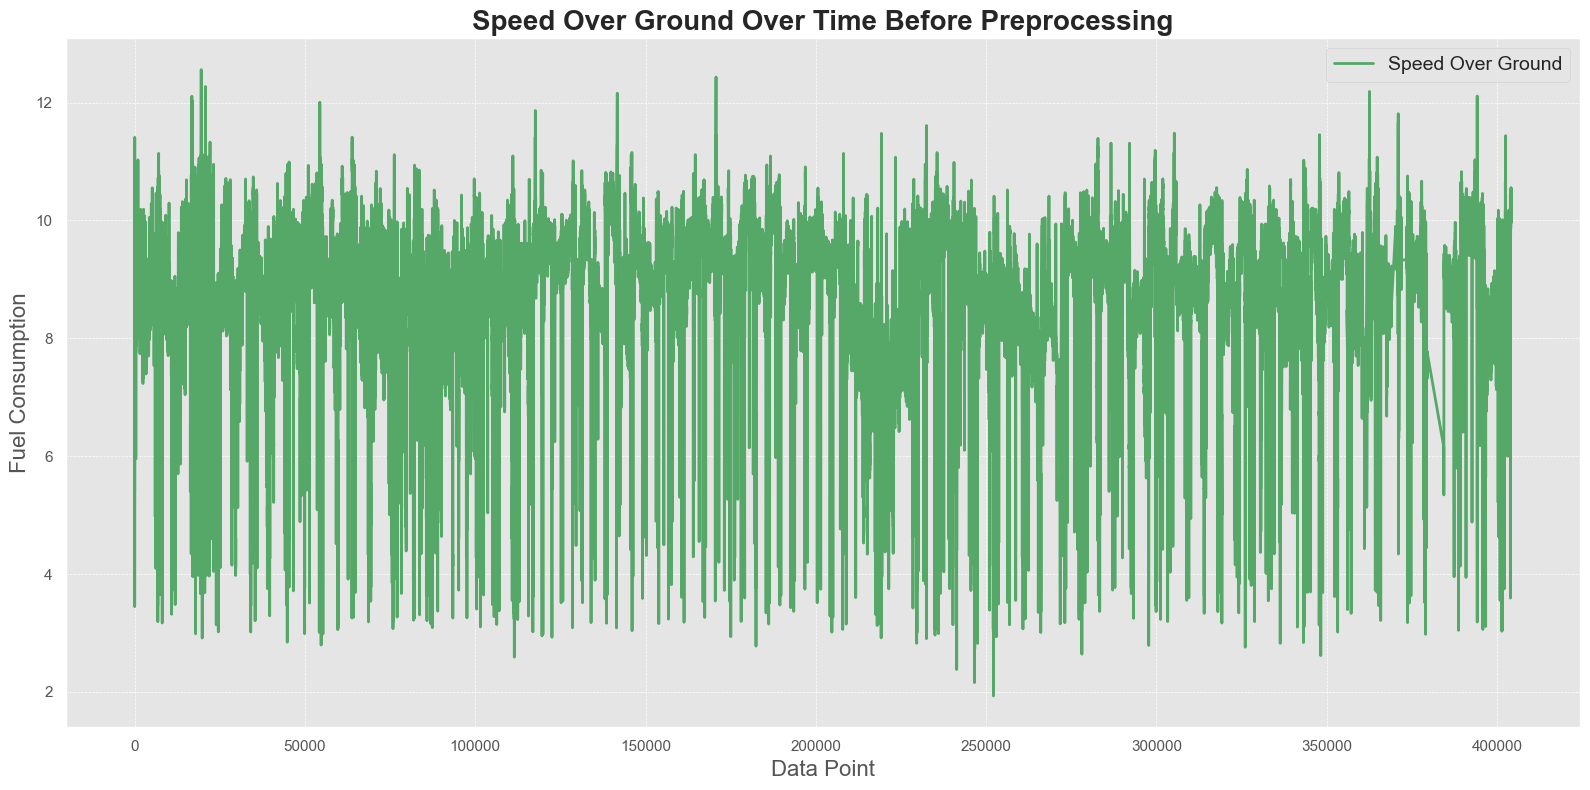

In [ ]:

plt.style.use('ggplot')
plt.figure(figsize=(16, 8))

plt.plot(vessel_1.index, vessel_1['speed_over_ground'], 'g-', label='Speed Over Ground', linewidth=2)

plt.title('Speed Over Ground Over Time Before Preprocessing', fontsize=20, fontweight='bold')
plt.xlabel('Data Point', fontsize=16)
plt.ylabel('Fuel Consumption', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()

plt.show()

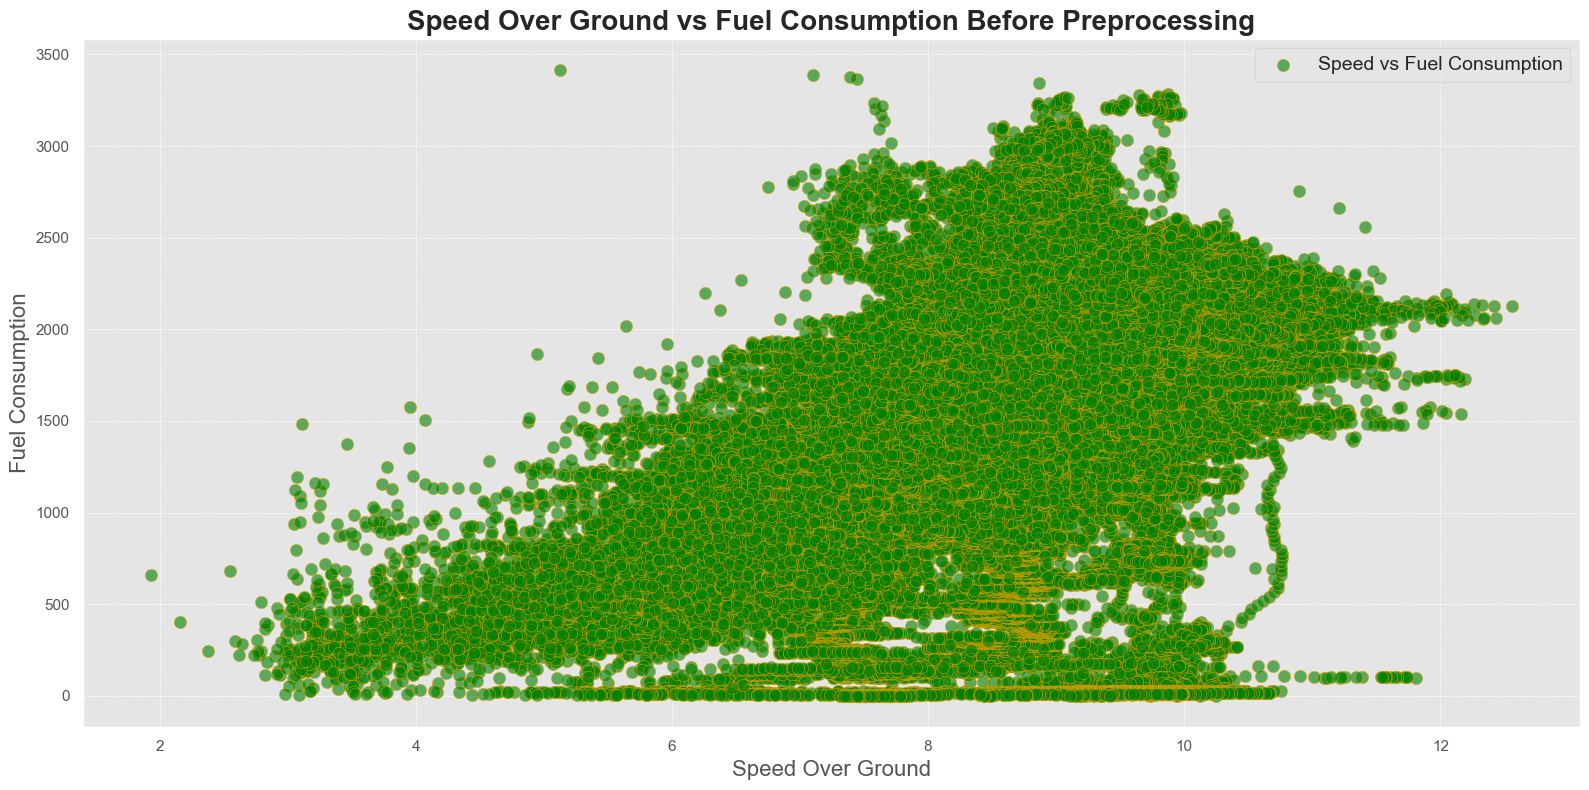

In [ ]:

plt.style.use('ggplot')
plt.figure(figsize=(16, 8))

plt.scatter(vessel_1['speed_over_ground'], vessel_1['fuel_consumption'], c='green', alpha=0.6, edgecolors='orange', s=80, marker='o', label='Speed vs Fuel Consumption')

plt.title('Speed Over Ground vs Fuel Consumption Before Preprocessing', fontsize=20, fontweight='bold')
plt.xlabel('Speed Over Ground', fontsize=16)
plt.ylabel('Fuel Consumption', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()

plt.show()



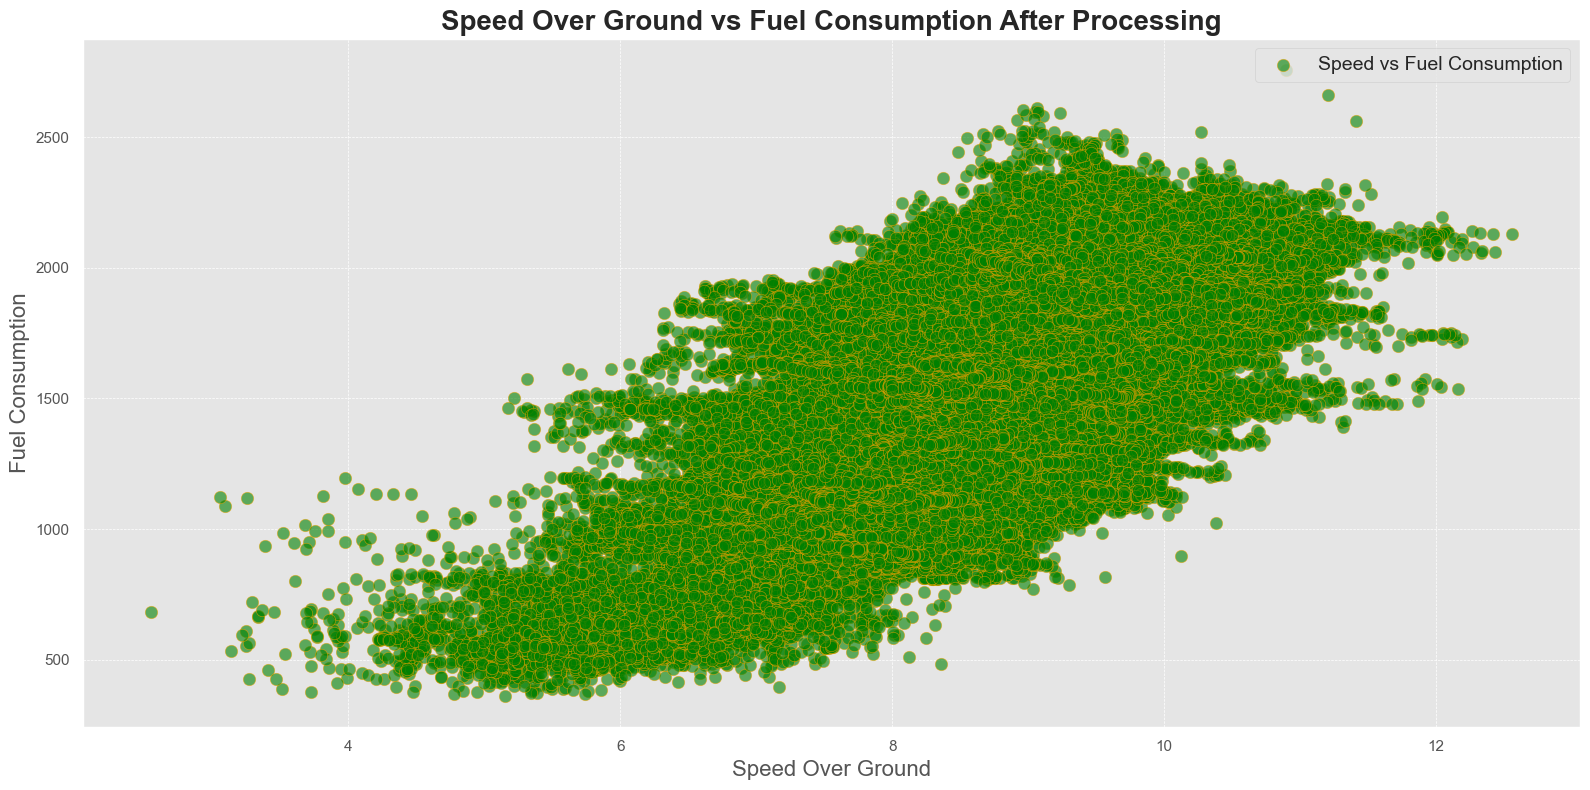

In [ ]:

plt.style.use('ggplot')
plt.figure(figsize=(16, 8))

plt.scatter(vessel1_preprocessed['speed_over_ground'], vessel1_preprocessed['fuel_consumption'], c='green', alpha=0.6, edgecolors='orange', s=80, marker='o', label='Speed vs Fuel Consumption')

plt.title('Speed Over Ground vs Fuel Consumption After Processing', fontsize=20, fontweight='bold')
plt.xlabel('Speed Over Ground', fontsize=16)
plt.ylabel('Fuel Consumption', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()

plt.show()